In [1]:
import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
from matplotlib import ticker, cm, colors


from extract_WEST_data import arc_length_div, E_ion_div, E_atom_div, ion_flux_div, \
    atom_flux_div, net_heat_flux_div, ind_target_div

Text(0, 0.5, 'Surface temperature (K)')

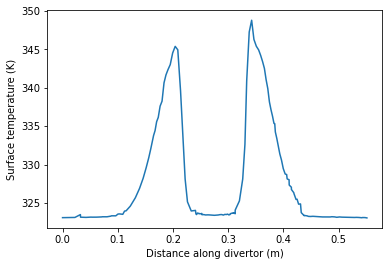

In [4]:
T = 1.1e-4*net_heat_flux_div + 323

plt.plot(arc_length_div, T)
plt.xlabel("Distance along divertor (m)")
plt.ylabel("Surface temperature (K)")

In [5]:
import numpy as np
def D(T):
    D_0_W = 1.9e-7
    E_D_W = 0.2
    return D_0_W*np.exp(-E_D_W/8.6e-5/T)
implantation_range_ions = 1.4e-10 * E_ion_div**0.64
implantation_range_atoms = 1.4e-10 * E_atom_div**0.64

c_max = ion_flux_div*implantation_range_ions/D(T) + atom_flux_div*implantation_range_atoms/D(T)
plt.plot(arc_length_div, c_max)

NameError: name 'np' is not defined